In [92]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 10

# Read in data and do basic massaging

In [93]:
df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,...,47,48,50,50,50,53,59,70,75,82
1,NaN,Japan,36.0,138.0,2,1,2,2,4,4,...,360,420,461,502,511,581,639,639,701,773


In [94]:
df = df_raw.drop(['Lat', 'Long'], axis=1)                   # drop the Lat/Lon columns
df = df.set_index(['Country/Region', 'Province/State'])     # set index (for rows) to country + state
df = df.stack().unstack(level=[0,1])                        # rotate so country+state is across top and dates go down
df.head(2)

Country/Region Thailand Japan Singapore Nepal Malaysia           Canada  \
Province/State      NaN   NaN       NaN   NaN      NaN British Columbia   
1/22/20               2     2         0     0        0                0   
1/23/20               3     1         1     0        0                0   

Country/Region       Australia                     Cambodia  ... Gabon  \
Province/State New South Wales Victoria Queensland      NaN  ...   NaN   
1/22/20                      0        0          0        0  ...     0   
1/23/20                      0        0          0        0  ...     0   

Country/Region Guatemala Guernsey Mauritania Rwanda Saint Lucia  \
Province/State       NaN      NaN        NaN    NaN         NaN   
1/22/20                0        0          0      0           0   
1/23/20                0        0          0      0           0   

Country/Region Saint Vincent and the Grenadines Suriname                   US  \
Province/State                              NaN      NaN Virgin Islands, U.S.   
1/22/20                                       0        0                    0   
1/23/20                                       0        0                    0   

Country/Region occupied Palestinian territory  
Province/State                            NaN  
1/22/20                                     0  
1/23/20                                     0  

[2 rows x 442 columns]

# Fix the State datasets for CA and NY
Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level. We need to create a merged California dataset with summation of counties before 3/10 and the 'Califorina' column from 3/10 onward

In [95]:
# Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level
idx =  pd.IndexSlice
df.loc['3/7/20':'3/12/20',idx[:,['California', 'Santa Clara County, CA', 'New York', 'Suffolk County, NY']]]

Country/Region       US                                                     
Province/State New York California Suffolk County, NY Santa Clara County, CA
3/7/20                0          0                  0                     32
3/8/20                0          0                  1                     38
3/9/20                0          0                  1                     38
3/10/20             173        144                  0                      0
3/11/20             220        177                  0                      0
3/12/20             328        221                  0                      0

In [96]:
# Create a merged California dataset with summation of counties before 3/10 and the
# 'Califorina' column from 3/10 onward
cal_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", CA")] # get all index entries (counties) ending in ", CA"
cal_locations = list(cal_locations.values)
cal_locations.append('California')                                              # include the 'California' state column to the list
cal_merged = df.loc[:, idx[:, cal_locations]].sum(axis=1)                       # cal_merged is the new California dataset

ny_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", NY")] # get all index entries (counties) ending in ", NY"
ny_locations = list(ny_locations.values)
ny_locations.append('New York')                                              # include the 'New York' state column to the list
ny_merged = df.loc[:, idx[:, ny_locations]].sum(axis=1)                      

cal_merged['3/7/20':'3/12/20']

3/7/20      81
3/8/20      95
3/9/20     101
3/10/20    144
3/11/20    177
3/12/20    221
dtype: int64

# Narrow down to a set of interesting countries plus California and graph

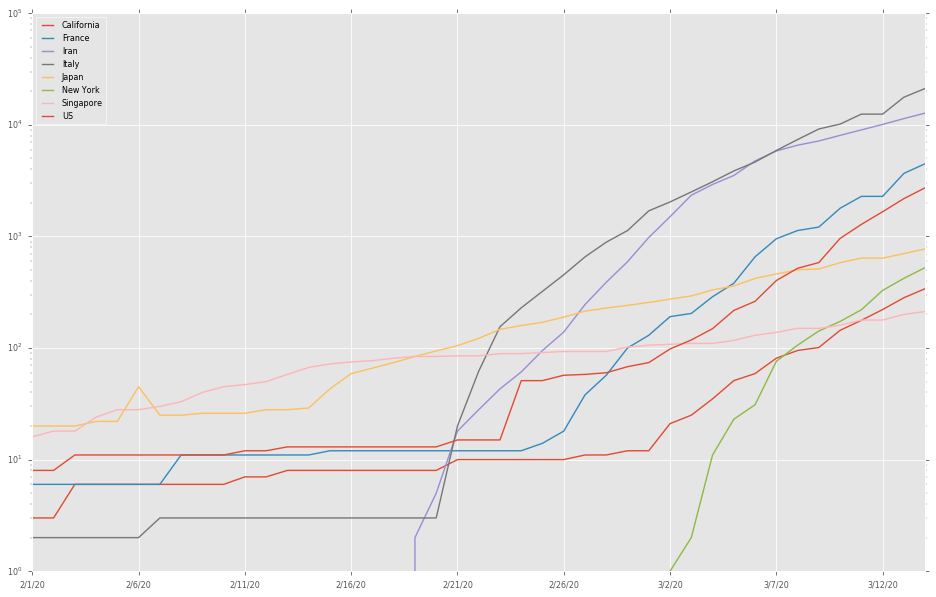

In [97]:
newdf = pd.DataFrame(index = df.index,
                     data = {
                         'Japan': df.loc[:, idx['Japan',:]].sum(axis=1),
                         'US': df.loc[:, idx['US',:]].sum(axis=1),
                         'Singapore': df.loc[:, idx['Singapore',:]].sum(axis=1),
                         'Italy': df.loc[:, idx['Italy',:]].sum(axis=1),
                         'Iran': df.loc[:, idx['Iran',:]].sum(axis=1),
                         'France': df.loc[:, idx['France',:]].sum(axis=1),
                         'California': cal_merged,
                         'New York': ny_merged,
                     }

)
newdf.loc['2/1/20':,:].plot(logy=True)

# Create a 'days since 100 cases' graph

In [98]:
newdf.head(2)

,California,France,Iran,Italy,Japan,New York,Singapore,US
1/22/20,0,0,0,0,2,0,0,1
1/23/20,0,0,0,0,1,0,1,1


['seaborn-white', 'fivethirtyeight', 'classic', 'grayscale', 'seaborn-colorblind', 'seaborn-notebook', 'bmh', 'seaborn', 'seaborn-poster', 'Solarize_Light2', 'ggplot', 'seaborn-ticks', 'seaborn-dark-palette', 'seaborn-pastel', 'seaborn-dark', 'dark_background', 'seaborn-darkgrid', 'seaborn-muted', 'tableau-colorblind10', 'seaborn-whitegrid', '_classic_test', 'seaborn-deep', 'seaborn-talk', 'seaborn-paper', 'seaborn-bright', 'fast']


Text(0, 0.5, 'Number of confirmed cases')

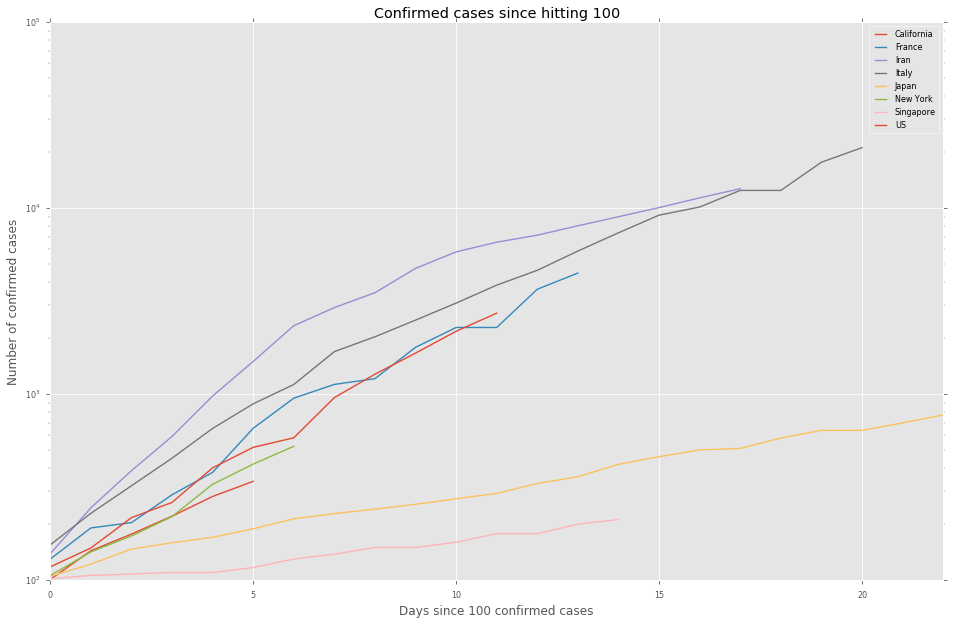

In [101]:
daysSince100 = pd.DataFrame(index=range(0,len(newdf.index)))
for location in newdf.columns:
    # create list of data once above 100
    tempList = [newdf.loc[date, location] 
                              for date in newdf[location].index 
                              if newdf.loc[date, location] > 100]
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled
daysSince100 = daysSince100.dropna(axis=0, how='all')
print(plt.style.available)
plt.style.use('ggplot')
ax = daysSince100.plot(title='Confirmed cases since hitting 100', logy=True)
ax.set_xlabel('Days since 100 confirmed cases')
ax.set_ylabel('Number of confirmed cases')